GIF/image2_3Clusters_k_means_plus_plus_Normalized.gif
iteration 1
k=1: 2070
k=2: 3633
k=3: 4297
diff0.49253926137869886


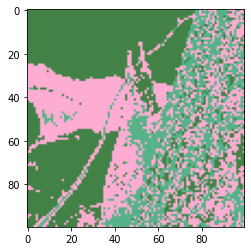

------------------------------------------------------------
iteration 2
k=1: 2200
k=2: 3864
k=3: 3936
diff0.020702564285082433


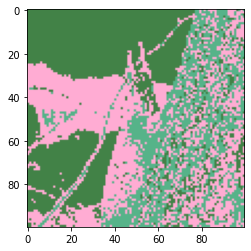

------------------------------------------------------------
iteration 3
k=1: 2263
k=2: 3959
k=3: 3778
diff0.004617226863734902


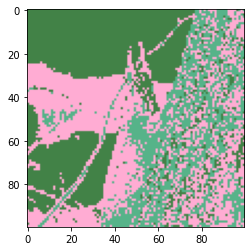

------------------------------------------------------------
iteration 4
k=1: 2296
k=2: 3989
k=3: 3715
diff0.0008696156278760478


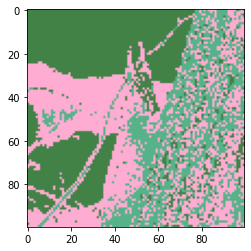

------------------------------------------------------------
iteration 5
k=1: 2312
k=2: 4008
k=3: 3680
diff0.0002534953206059878


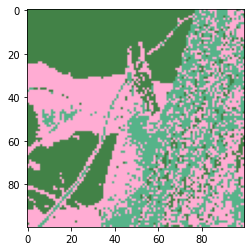

------------------------------------------------------------
iteration 6
k=1: 2321
k=2: 4007
k=3: 3672
diff2.682200433906367e-05


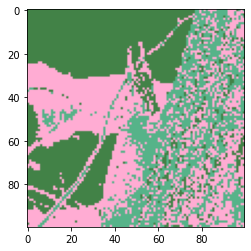

------------------------------------------------------------
iteration 7
k=1: 2325
k=2: 4006
k=3: 3669
diff4.651523707990244e-06


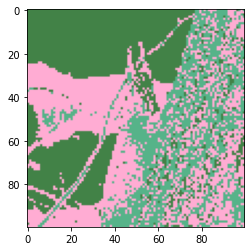

------------------------------------------------------------
iteration 8
k=1: 2326
k=2: 4007
k=3: 3667
diff8.89763486289403e-07


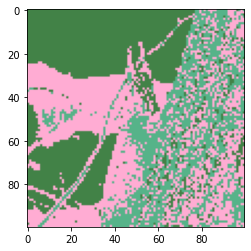

------------------------------------------------------------
iteration 9
k=1: 2326
k=2: 4007
k=3: 3667
diff0.0


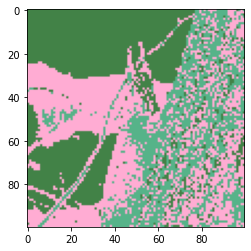

------------------------------------------------------------


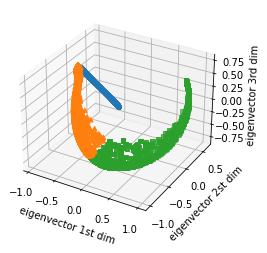

In [12]:
import numpy as np
import cv2
import os
from scipy.spatial.distance import pdist,squareform
import matplotlib.pyplot as plt
from array2gif import write_gif
#----------------------------------------------------------------------------------------
def imread(img_path):
    """
    param img_path
    return a flatten image array (H*W,C)
    want to know image.reshape OK??
    """
    image = cv2.imread(img_path)
    H,W,C = image.shape
    image_flatten = np.zeros((W*H,C))
    #image_flatten = image.reshape(W*H,C)
    for i in range(H):
        image_flatten[i*W:(i+1)*W] = image[i]
    return image_flatten , H , W
#----------------------------------------------------------------------------------------
def precomputed_kernel(X,gamma_spatial,gamma_color):
    """
    kernel function: k(x,x')= exp(-r_s*||S(x)-S(x')||**2)* exp(-r_c*||C(x)-C(x')||**2)
    X: (H*W=10000,rgb=3) array
    """
    n = len(X)
    
    S = np.zeros((n,2))
    for i in range(n):
        S[i] = [i//100,i%100]
    spatial = np.exp(-gamma_spatial*pdist(S,'sqeuclidean'))
    spatial = squareform(spatial)

    color = np.exp(-gamma_color*pdist(X,'sqeuclidean'))
    color = squareform(color)
    
    answer_kernel = spatial * color 
    return answer_kernel
#----------------------------------------------------------------------------------------
def save_gif(segments,gif_path):
    for i in range(len(segments)):
        segments[i] = segments[i].transpose(1,0,2)
    write_gif(segments,gif_path , fps = 2)
#----------------------------------------------------------------------------------------    
def initial_mean(X,k,initType):
    """
    X : ( H*W , 3 features)
    k : k klusters
    initType : 'random' , 'pick' , 'k_means_plusplus'
    Cluster : (k,3)
    
    """
    Cluster = np.zeros((k,X.shape[1]))
    
    if initType == 'k_means_plus_plus':
        
        #randomly choose one to be a cluster_mean
        Cluster[0] = X[np.random.randint(low=0,high=X.shape[0],size=1),:]
        
        #choose another k-1 cluster_mean
        for c in range(1,k):
            Dist_matrix = np.zeros((len(X),c))
            for i in range(len(X)):
                for j in range(c):
                    Dist_matrix[i,j] = np.sqrt(np.sum((X[i]-Cluster[j])**2))            
            #這邊應該要用先對橫向找到最小值(計算所有點到其最近的質心的距離)
            #使用輪盤法找到下一個質心
            #https://zhuanlan.zhihu.com/p/32375430
            Dist_min = np.min(Dist_matrix,axis=1)
            sum = np.sum(Dist_min)*np.random.rand()
            for i in range(len(X)):
                sum = sum - Dist_min[i]
                if sum<=0:
                    Cluster[c] = X[i]
                    break

    if initType == 'random_nor':
        X_mean = np.mean(X,axis=0)
        X_std  = np.std(X,axis =0)
        for i in range(X.shape[1]):
            Cluster[:,i] = np.random.normal(X_mean[i],X_std[i],size = k)
            
    if initType =='random':
        random_pick=np.random.randint(low=0,high=X.shape[0],size=k)
        Cluster=X[random_pick,:]
        
    return Cluster
            
        
#----------------------------------------------------------------------------------------
colormap= np.random.choice(range(256),size=(100,3))
def visualize(X,k,H,W,colormap):
    """
    """
    colors = colormap[:k,:]
    res = np.zeros((H,W,3))
    for h in range(H):
        for w in range(W):
            res[h,w,:] = colors[X[h*W+w]]
            
    return res.astype(np.uint8)
#----------------------------------------------------------------------------------------
def k_means(X,k,H,W,initType='random',gifPath='default.gif'):
    """
    Want to do k klusters
    X : ( H*W , 3 features )
    k : k klusters
    
    """
    EPS = 1e-9
    Mean = initial_mean(X,k,initType)
    #Classes of each Xi
    C = np.zeros(len(X),dtype = np.uint8)
    segments = []
    
    diff = 1e9
    count = 1 
    while diff>EPS:
        # E-step
        for i in range(len(X)):
            dist = []
            for j in range(k):
                dist.append(np.sqrt(np.sum((X[i]-Mean[j])**2)))
            C[i] = np.argmin(dist)
        
        #M-step
        New_Mean = np.zeros(Mean.shape)
        for i in range(k):
            belong = np.argwhere(C==i).reshape(-1)
            for j in belong:
                New_Mean[i] = New_Mean[i] + X[j]
            if len(belong)>0:
                New_Mean[i] = New_Mean[i]/len(belong)
        diff = np.sum((New_Mean - Mean)**2)
        Mean = New_Mean
        
        #visualize
        segment = visualize(C,k,H,W,colormap)
        segments.append(segment)
        print('iteration {}'.format(count))
        for i in range(k):
            print('k={}: {}'.format(i+1 , np.count_nonzero(C==i)))
        print('diff{}'.format(diff))
        

        plt.clf()
        plt.imshow(cv2.cvtColor(segment, cv2.COLOR_BGR2RGB))
        plt.pause(0.001)
        print('------------------------------------------------------------')
        
        count =count+1
    return C , segments    
#----------------------------------------------------------------------------------------
def plot_eigenvector_3(x,y,z,C):
    """
    x y z datapoint array
    C belonging class
    """
    fig = plt.figure()
    ax  = fig.add_subplot(111,projection='3d')
    markers=['o','^','s']
    for marker , i in zip(markers,np.arange(3)):
        ax.scatter(x[C==i],y[C==i],z[C==i],marker=marker)
    ax.set_xlabel('eigenvector 1st dim')
    ax.set_ylabel('eigenvector 2st dim')
    ax.set_zlabel('eigenvector 3rd dim')
    plt.show()
#----------------------------------------------------------------------------------------
def plot_eigenvector_2(x,y,C):
    fig = plt.figure()
    markers=['o','^']
    for marker , i in zip(markers,np.arange(2)):
        plt.scatter(x[C==i],y[C==i],marker=marker)
    plt.xlabel('eigenvector 1st dim')
    plt.ylabel('eigenvector 2st dim')
    plt.show()    
#----------------------------------------------------------------------------------------   
    
if __name__ =='__main__':
    img_path = 'image2.png'
    image_flatten , H , W = imread(img_path)

    gamma_spatial = 0.001
    gamma_color   = 0.001

    k = 3  # k clusters
    k_means_initType = 'k_means_plus_plus'
    #k_means_initType='random_nor'
    #k_means_initType='random'
    
    gif_dir = './GIF'
    gif_path=os.path.join("GIF/%s_%sClusters_%s_Normalized.gif"%(img_path.split('.')[0],k,k_means_initType))
    if not os.path.isdir(gif_dir):
        os.mkdir(gif_dir)
    print(gif_path)
    
    """
    WW = precomputed_kernel(image_flatten,gamma_spatial,gamma_color)
    D = np.diag(np.sum(WW,axis=1))
    L = D-WW
    D_inverse_square= np.diag(1/np.diag(np.sqrt(D)))
    L = np.dot(np.dot(D_inverse_square,L),D_inverse_square)

    
    eigenvalue , eigenvector = np.linalg.eig(L)
    np.save('{}_eigenvalue_{:.3f}_{:.3f}_normalized.npy'.format(img_path.split('.')[0],gamma_spatial,gamma_color),eigenvalue)
    np.save('{}_eigenvector_{:.3f}_{:.3f}_normalized.npy'.format(img_path.split('.')[0],gamma_spatial,gamma_color),eigenvector)
    print("finish")
    """
    
    eigenvalue = np.load('{}_eigenvalue_{:.3f}_{:.3f}_normalized.npy'.format(img_path.split('.')[0],gamma_spatial,gamma_color))
    eigenvector = np.load('{}_eigenvector_{:.3f}_{:.3f}_normalized.npy'.format(img_path.split('.')[0],gamma_spatial,gamma_color))
    sort_index = np.argsort(eigenvalue)
    
    HH = eigenvector[:,sort_index[1:k+1]]
    
    sums = np.sqrt(np.sum(np.square(HH),axis=1)).reshape(-1,1)
    HH = HH/sums
    
    belonging,segments=k_means(HH,k,H,W,initType=k_means_initType)
    save_gif(segments,gif_path)
    if k==3:
        plot_eigenvector_3(HH[:,0],HH[:,1],HH[:,2],belonging)
    if k==2:
        plot_eigenvector_2(HH[:,0],HH[:,1],belonging)
    